In [27]:
using Revise
ENV["JULIA_CUDA_USE_COMPAT"] = false
using CUDA
using BenchmarkTools

### NVIDIA Tools Extensions

To accurately measure the total time it takes to execute this operation, you can use the mouse to measure on the timeline. A better approach is to denote the operation in source code, using NVIDIA's Tools Extensions (NVTX) library. This will then be picked up by NSight Systems, and added to the timeline:

In [28]:
A = CUDA.rand(Float32, 1024, 1024)
B = CUDA.rand(Float32, 1024, 1024)
CUDA.@profile NVTX.@range "mul!" CUDA.@sync A * B;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


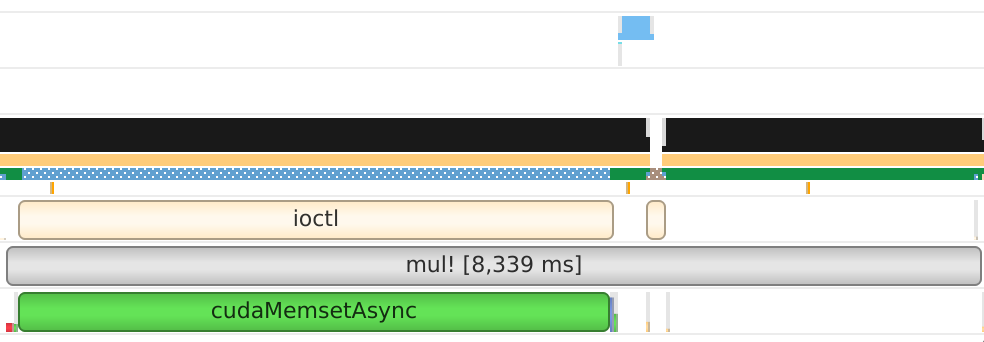

Note how our NVTX range nicely includes the time it took to queue the operation, as well as the execution on the GPU. This requires the NVTX range to include a synchronization!

The initial API call here is suspiciously slow though. This is a common occurence, and therefore it's recommended to profile any short-running application twice:

In [29]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


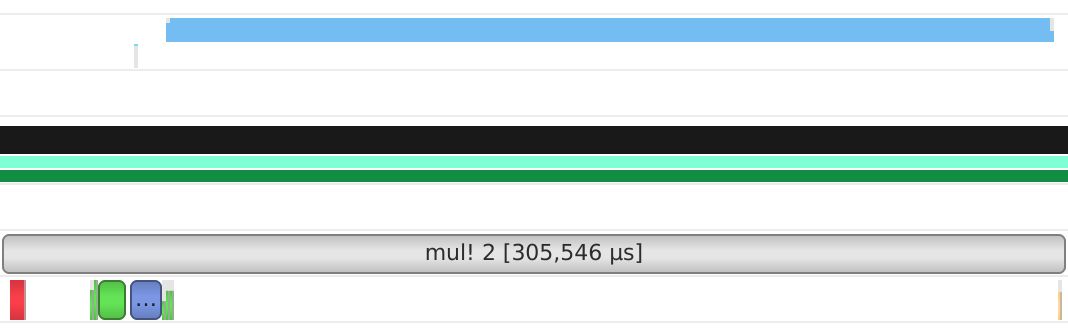

That's better, and much closer to our earlier benchmark results. Notice that it is still slightly slower, and some overhead is to be expected when running under the profiler.

NVTX can also be used to add markers to the source code:

In [30]:
CUDA.@profile begin
    NVTX.@range "mul! 1" CUDA.@sync A * B
    NVTX.@range "mul! 2" CUDA.@sync A * B
    NVTX.mark("done")
end;


waiting for capture range to start the collection
command ignored
┌ Info: Profiling has finished, open the report listed above with `nsight-sys`
└ @ CUDA.Profile /home/tim/Julia/pkg/CUDA/lib/cudadrv/profile.jl:91


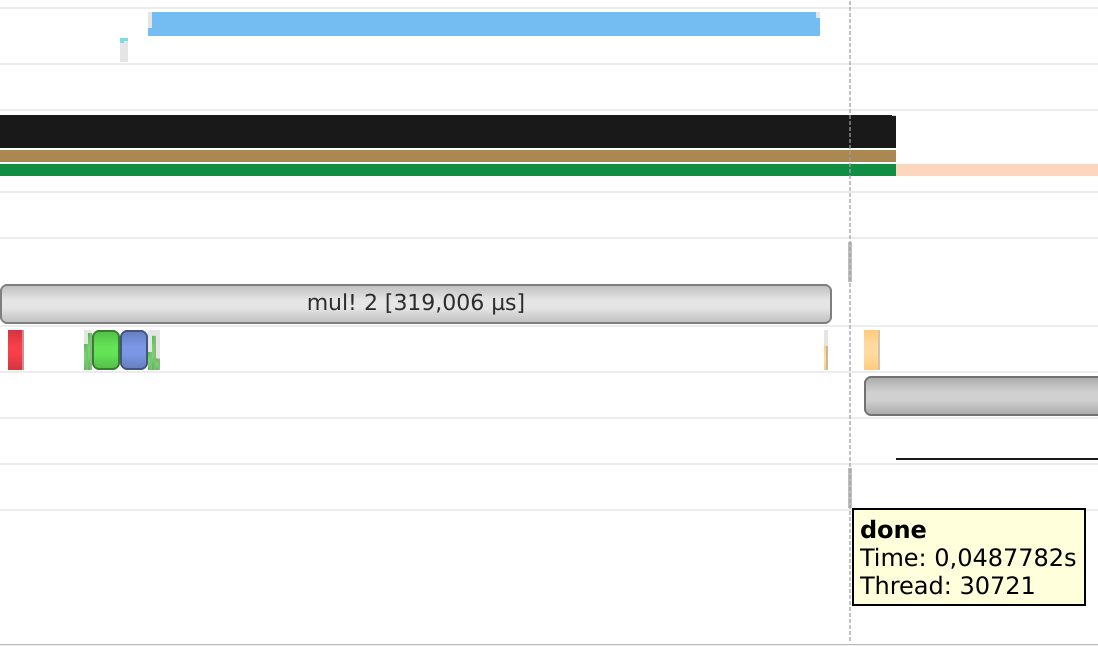

For details on the kernel's execution, expand the `GPU` part of the timeline and hover the kernel in question:

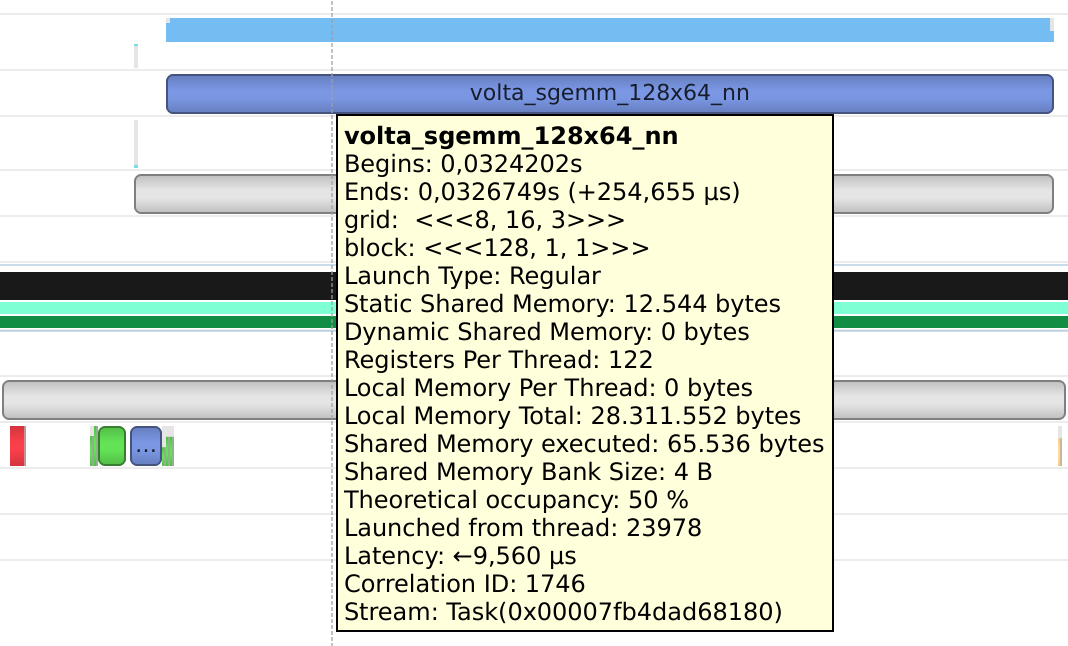

That gives some useful information on the kernel, but generally, there's more low-hanging fruit at the application level rather than at individual kernels.

## Case study: application optimization

As a case study, let's look at a sequence of operations that computes the RMSE of a batch of matrices:

In [32]:
N = 16
A = CUDA.rand(1024, 1024, N)
B = CUDA.rand(1024, 1024, N)
CUDA.allowscalar(false)

In [31]:
NVTX.@range function rmse(A::AbstractMatrix, B::AbstractMatrix)
    E = A - B
    SQE = E .^ 2
    MSE = sum(SQE) / length(SQE)
    return sqrt(MSE)
end

rmse (generic function with 1 method)

In [33]:
NVTX.@range function doit(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(A[:, :, i], B[:, :, i])
    end
    rmses
end

doit (generic function with 1 method)

In [34]:
@benchmark doit(rmse)

BenchmarkTools.Trial: 540 samples with 1 evaluation.
 Range (min … max):  2.755 ms … 294.130 ms  ┊ GC (min … max): 0.00% … 1.12%
 Time  (median):     3.349 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.261 ms ±  39.446 ms  ┊ GC (mean ± σ):  0.72% ± 0.16%

  █                                                            
  █▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆ ▆
  2.76 ms      Histogram: log(frequency) by time       281 ms <

 Memory estimate: 114.97 KiB, allocs estimate: 2706.

<div class="alert alert-info">
Explicit synchronization is not required here, since we fetch the GPU memory by calling the `Array` function which requires the GPU to be idle.
</div>

To determine whether we're using the GPU efficiently, let's look at a timeline:

In [35]:
#CUDA.@profile (doit(rmse); doit(rmse))

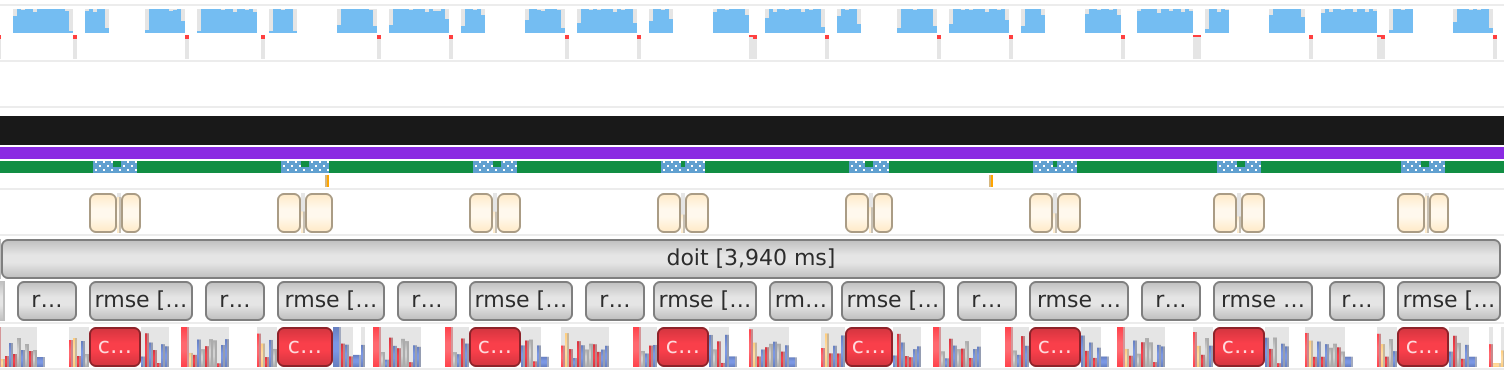

What we're generally looking for, is a continuous stream of kernels that keeps the GPU busy. That's not the case here, as there's lots of white space between blocks of kernels indicating the GPU is essentially idle at that time. This is generally caused by the CPU not being able to queue work quickly enough, so we need to avoid needless operations between launching subsequent kernels.

For example, there's some time being wasted before every invocation of the `rmse` function:

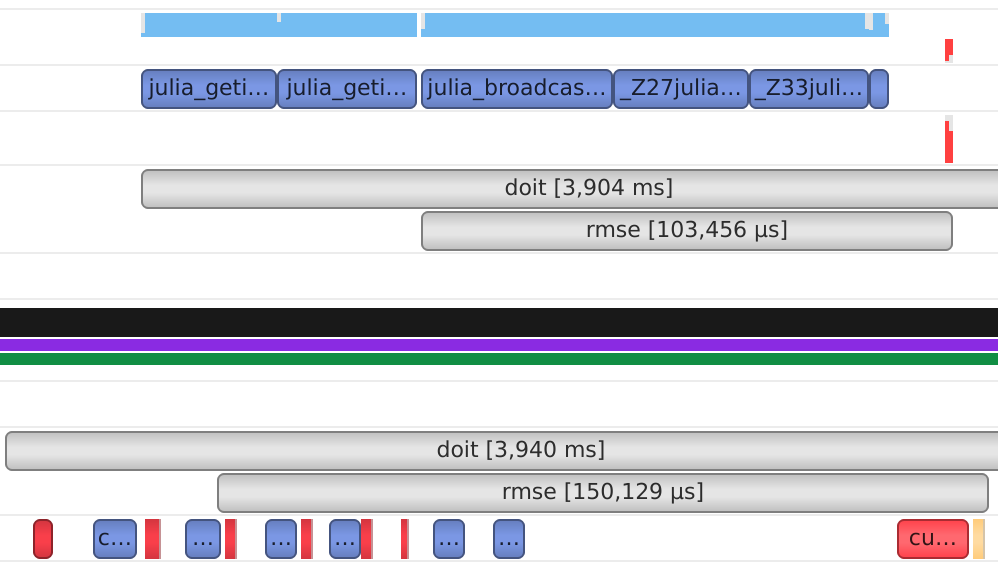

The cause for the overhead is the slicing of arrays, which copies data! Let's convert it into a view instead:

In [36]:
NVTX.@range function doit2(f)
    rmses = Vector{Float64}(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    rmses
end

doit2 (generic function with 1 method)

In [37]:
@benchmark doit2(rmse)

BenchmarkTools.Trial: 975 samples with 1 evaluation.
 Range (min … max):  1.958 ms … 283.754 ms  ┊ GC (min … max): 0.00% … 1.23%
 Time  (median):     2.104 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.211 ms ±  28.109 ms  ┊ GC (mean ± σ):  0.76% ± 0.14%

  █ ▁                                                          
  ███▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▇
  1.96 ms      Histogram: log(frequency) by time      57.2 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

In [38]:
#CUDA.@profile (doit2(rmse); doit2(rmse))

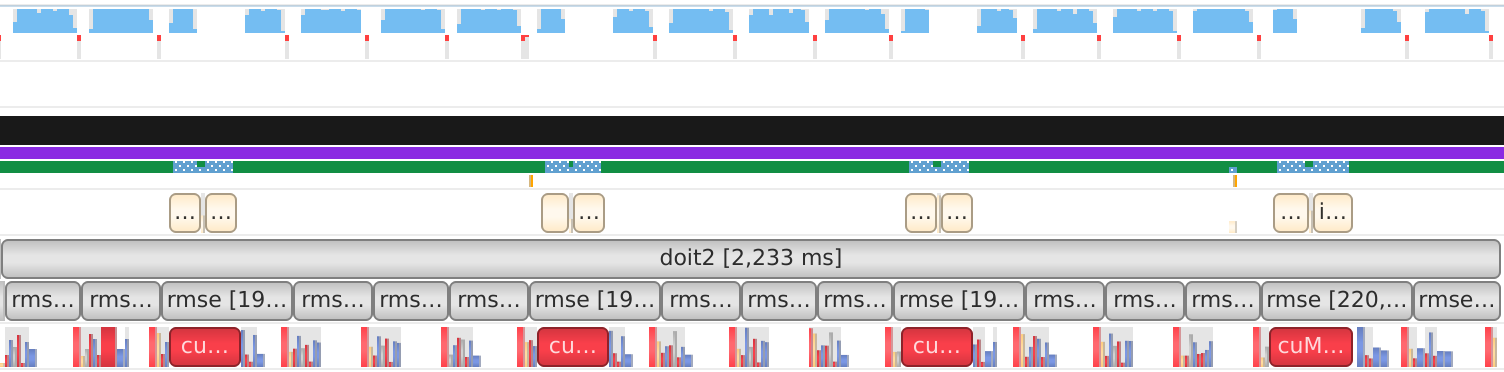

The invocations of the `rmse` function are now closely packed together, but the GPU trace itself is still very sparse: Lots of kernels are being launched, and there's lots of time where the GPU is essentially idle.

One typical approach to improving this is to fuse kernels:

In [39]:
NVTX.@range function rmse2(A::AbstractMatrix, B::AbstractMatrix)
    SQE = (A - B) .^ 2
    MSE = sum(SQE) / length(A)
    return sqrt(MSE)
end

rmse2 (generic function with 1 method)

In [40]:
@benchmark doit2(rmse2)

BenchmarkTools.Trial: 975 samples with 1 evaluation.
 Range (min … max):  1.963 ms … 290.204 ms  ┊ GC (min … max): 0.00% … 1.49%
 Time  (median):     2.108 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.167 ms ±  28.155 ms  ┊ GC (mean ± σ):  0.80% ± 0.14%

  █▂                                                           
  ██▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃ ▇
  1.96 ms      Histogram: log(frequency) by time        44 ms <

 Memory estimate: 76.97 KiB, allocs estimate: 1522.

In [41]:
#CUDA.@profile (doit2(rmse2); doit2(rmse2))

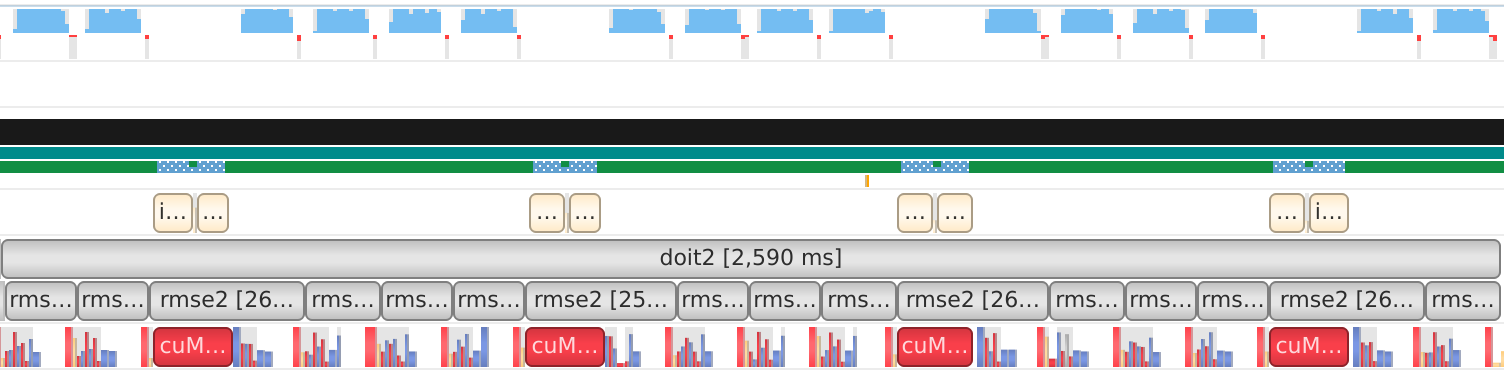

Not much of an improvement! That's because even though we saved quite some time on the GPU, the CPU was spending time doing some allocations and the GPU usage just became even more sparse. The good news is that by fusing even more, we also get rid of these temporaries, so it's a two-fold advantage:

In [42]:
NVTX.@range function rmse3(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B) / length(A)
    return sqrt(MSE)
end

rmse3 (generic function with 1 method)

In [43]:
@benchmark doit2(rmse3)

BenchmarkTools.Trial: 3994 samples with 1 evaluation.
 Range (min … max):  937.088 μs … 55.010 ms  ┊ GC (min … max): 0.00% … 26.64%
 Time  (median):       1.073 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.249 ms ±  1.865 ms  ┊ GC (mean ± σ):  1.40% ±  0.93%

  ▂▅▇██▇▇▆▅▃▂ ▁▁▁▂▁▁ ▁▁▂▃▃▃▃▃▃▂▁   ▁                           ▂
  ███████████████████████████████████▇█▇▇▆▅▇▁▄▅▆▅▄▄▄▄▄▄▄▄▄▁▄▄▇ █
  937 μs        Histogram: log(frequency) by time      2.45 ms <

 Memory estimate: 61.97 KiB, allocs estimate: 1218.

In [44]:
#CUDA.@profile (doit2(rmse3); doit2(rmse3))

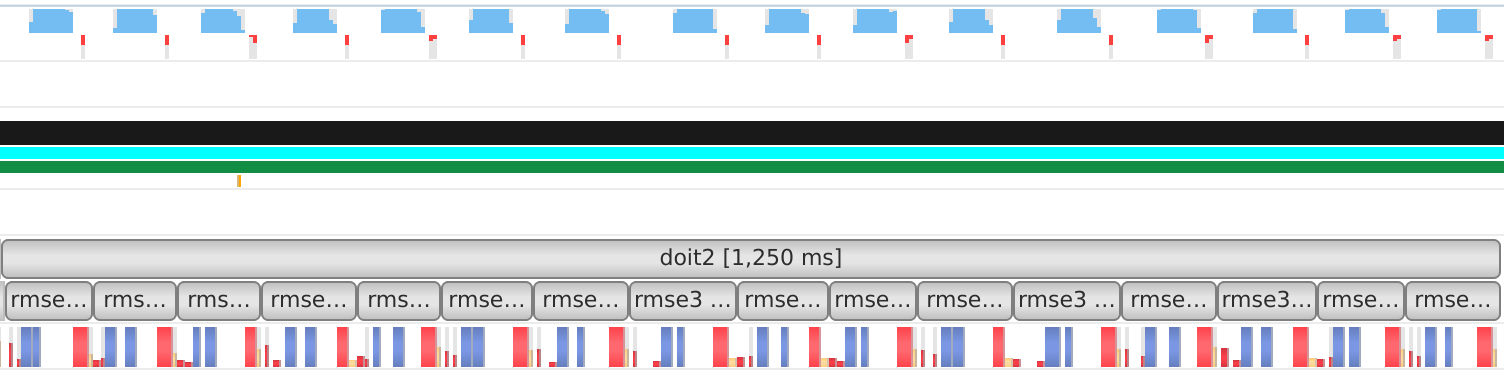

By fusing even more, we god rid of some costly temporaries. Yet the trace is still sparse. That's because `mapreduce` returns a scalar, so it needs to wait for the GPU to finish (i.e. it synchronizes execution). Let's reduce to a 1-element array instead, which we then fetch after having processed all batches:

In [45]:
NVTX.@range function rmse4(A::AbstractMatrix, B::AbstractMatrix)
    @assert size(A) == size(B)
    MSE = mapreduce((a,b)->(a - b) ^ 2, +, A, B; dims=(1,2)) ./ length(A)
    return sqrt.(MSE)
end

NVTX.@range function doit3(f)
    rmses = Vector(undef, N)
    for i in 1:N
        rmses[i] = f(view(A, :, :, i), view(B, :, :, i))
    end
    map(rmses) do rmse
        Array(rmse)[]
    end
end

doit3 (generic function with 1 method)

In [46]:
@benchmark doit3(rmse4)

BenchmarkTools.Trial: 4233 samples with 1 evaluation.
 Range (min … max):  714.351 μs … 74.900 ms  ┊ GC (min … max): 0.00% … 21.24%
 Time  (median):     996.827 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.178 ms ±  2.867 ms  ┊ GC (mean ± σ):  2.09% ±  0.85%

         ▃▆▇▇█▇▆▅▂▂                                             
  ▂▁▂▃▄▅▇███████████▇▆▅▄▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▄
  714 μs          Histogram: frequency by time         1.98 ms <

 Memory estimate: 79.38 KiB, allocs estimate: 1686.

In [47]:
#CUDA.@profile (doit3(rmse4); doit3(rmse4))

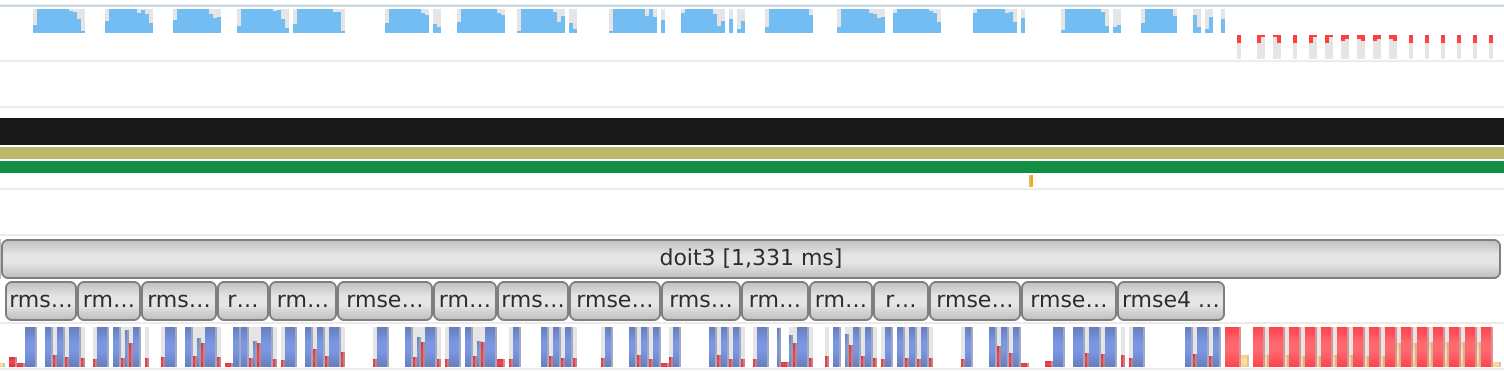

Quite an improvement! All synchronizing operations now happen at the end of the loop, so the GPU can keep on computing uninterruptedly. But at the end, we still require a bunch of memory operations; let's use a single buffer that we can fetch using a single memory copy. We can do so using `mapreducedim!`, a low-level abstraction that takes the destination array as an argument. The disadvantage of this API is that it only accepts a single input array, so we need to manually instantiate the broadcast (we could also do this using LazyArrays.jl):

In [48]:
NVTX.@range function rmse5(A::AbstractMatrix, B::AbstractMatrix, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    MSE = Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ length(SQE))
    return
end

NVTX.@range function doit4(f)
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    
    for i in 1:N
        f(view(A, :, :, i), view(B, :, :, i), reshape(view(rmses, i), 1, 1))
    end
    Array(rmses)
end

doit4 (generic function with 1 method)

In [49]:
@benchmark doit4(rmse5)

BenchmarkTools.Trial: 5172 samples with 1 evaluation.
 Range (min … max):  604.962 μs … 52.860 ms  ┊ GC (min … max): 0.00% … 30.73%
 Time  (median):     863.859 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   963.744 μs ±  1.627 ms  ┊ GC (mean ± σ):  1.78% ±  1.04%

        ▂▃▄▅▇▆█▅▅▄▄▂▁▄▁                                         
  ▁▁▂▃▅▇███████████████▇█▆▅▅▅▄▄▃▃▃▂▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  605 μs          Histogram: frequency by time         1.63 ms <

 Memory estimate: 64.09 KiB, allocs estimate: 1192.

In [50]:
#CUDA.@profile (doit4(rmse5); doit4(rmse5))

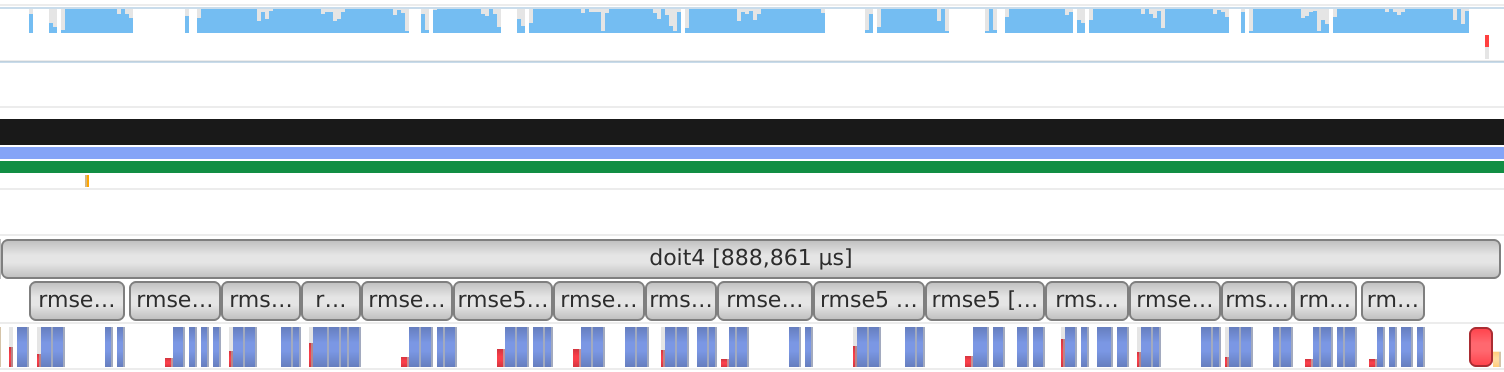

Now the GPU trace is starting to look nicely packed.

Of course, this entire exercise is slightly contrived, and we could have started out by getting rid of the `for` loop and using array operations across the batch dimension:

In [51]:
NVTX.@range function rmse6(A::AbstractArray, B::AbstractArray, C::AbstractArray)
    SQE = Broadcast.broadcasted(A, B) do a,b
        (a - b) ^ 2
    end
    SQE = Broadcast.instantiate(SQE)
    MSE = Base.mapreducedim!(identity, +, C, SQE)
    C .= sqrt.(C ./ prod(size(A)[1:2]))
    return
end

NVTX.@range function doit5(f)
    rmses = similar(A, 1, 1, N)
    fill!(rmses, zero(eltype(A)))
    f(A, B, rmses)
    Array(rmses)
end

doit5 (generic function with 1 method)

In [52]:
@benchmark doit5(rmse6)

BenchmarkTools.Trial: 8103 samples with 1 evaluation.
 Range (min … max):  530.363 μs …   1.952 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     582.633 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   612.191 μs ± 109.096 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▃▆▇▆▆▆█▇▆▃▂▂▁        ▁▁       ▁        ▂▃                     ▂
  ██████████████▆▆▅▇▇▇███▇▆▆▄▂▄▇██▆▆▆▄▆██████▇▅▅▄▇▆██▇▇▇▆▅▅▅▄▅▆ █
  530 μs        Histogram: log(frequency) by time       1.03 ms <

 Memory estimate: 4.86 KiB, allocs estimate: 84.

In [53]:
#CUDA.@profile (doit5(rmse6); doit5(rmse6))

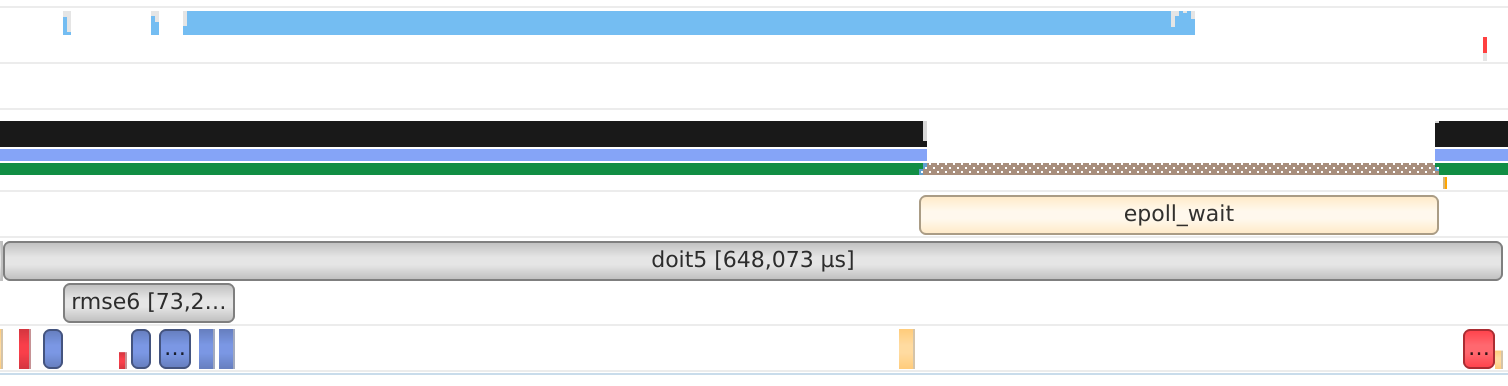

By getting rid of the loop, we only need to launch a single series of kernels, so the effects of using unfused kernels would have been less pronounced. Still, the individual optimizations were worth it, even when processing all batches at once.

Summarized, when optimizing a GPU application it's good to:

- fuse operations: avoids temporaries, reduces launch overhead, and enables global optimization
- bundle memory operations: pre-allocation, fetch results at the end
- avoid synchronization

Many of these optimization can be implemented generically, i.e., without introducing GPU-specific operations (e.g. avoiding calls to constructors but use `similar`, ...). As a result, it's still possible to use the above functions with CPU arrays, even with the NVTX annotations still attached to them:

In [54]:
A = rand(Float32, 1024, 1024, N)
B = rand(Float32, 1024, 1024, N)
@benchmark doit3(rmse4)

BenchmarkTools.Trial: 277 samples with 1 evaluation.
 Range (min … max):  16.457 ms … 26.645 ms  ┊ GC (min … max):  0.00% … 7.96%
 Time  (median):     18.786 ms              ┊ GC (median):    11.38%
 Time  (mean ± σ):   18.044 ms ±  1.327 ms  ┊ GC (mean ± σ):   6.61% ± 5.71%

    ▃▇▃▁                           ▂▇█▃▁                       
  ▄▄████▄▃▃▄▄▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▃▄█████▄▄▄▂▂▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂ ▃
  16.5 ms         Histogram: frequency by time        20.6 ms <

 Memory estimate: 64.01 MiB, allocs estimate: 326.